# Fitting granular shear flow of elongated particles with noisy Jeffrey Orbits

In [1]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import pickle
from matplotlib.ticker import MultipleLocator, FuncFormatter
import itertools

### Plotting Utilities

In [2]:
# Set the ticks as functions of pi
def pi_formatter(x, pos):
    fractions = {0: '0', np.pi/4: r'$\pi/4$', np.pi/2: r'$\pi/2$', 
                 3*np.pi/4: r'$3\pi/4$', np.pi: r'$\pi$'}
    return fractions.get(x, f'{x/np.pi:.2g}π')

def plot_pdf_and_fit(alpha_values, noise, exponent):

    plt.figure(figsize=(10, 6))
    
    colormap = plt.cm.RdYlBu
    num_colors = len(alpha_values)
    extreme_indices = np.concatenate([
        np.linspace(0, 0.3, num_colors // 2, endpoint=False),  # Lower 30%
        np.linspace(0.7, 1.0, num_colors - num_colors // 2)    # Upper 30%
    ])
    colors = [colormap(i) for i in extreme_indices]
    
    # Insert a unique color for the central aspect ratio
    central_color = 'black'
    central_ap = 1.0  # Replace with the actual central value of aspect ratio
    
    try:
        central_index = alpha_values.index(central_ap)
    except ValueError:  # Raised if central_ap is not in alpha_values
        central_index = 0
    # Insert the central color
    colors.insert(central_index, central_color)
    # Plot the fit results
    for i, alpha in enumerate(alpha_values):
        # Solve the model with optimized parameters
        theta_x, model_solution = solve_for_alpha_fit(alpha, optimized_noise, optimized_exponent)
    
        # Get the actual data for this alpha value
        actual_theta_x, actual_p = actual_data[i]
    
        # Plot the actual data
        plt.plot(actual_theta_x, actual_p, 'o', markersize = 0.5, label=f"Actual Data (α = {alpha})", color=colors[i])
    
        # Plot the model solution
        plt.plot(theta_x, model_solution, '-', label=f"Fit (α = {alpha})", color=colors[i])
    
    # Customize the plot
    plt.xlabel('$\\theta_x$ [rad]', fontsize=18)
    plt.ylabel('$\\psi[\\theta_x]$', fontsize=18)
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=np.pi/4))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    plt.gca().tick_params(axis='x', labelsize=14)
    plt.gca().tick_params(axis='y', labelsize=14)
    
    plt.title(f'Circular PDF of Angular Distribution ($\\mu_p={cof}$, $I={I}$) and fit Fokker-Planck', fontsize=16)
    plt.grid(True)
    plt.show()

## Solving the jeffrey orbits differential equation

In [21]:
# Define Beta function
def Beta(alpha):
    # return (alpha**2 - 1) / (alpha**2 + 1)
    return (alpha**2 - 1) / (alpha**2 + 1)

# Define f function as in Talbot PRE (2024)
def f(theta_x, alpha):
    return -Gamma / 2 * (1.0 - Beta(alpha) * np.cos(2 * theta_x))

# Define epsilon function
def epsilon_fixed(alpha, noise):
    return noise * alpha**-6 #assuming rotational diffusion goes as power-law

In [4]:
def ode(theta_x, p, alpha, epsilon):
        """Defines the system of ODEs for the solver."""
        dp_dtheta_x = (f(theta_x, alpha) * p[0] + c) / epsilon(alpha)
        return np.array([dp_dtheta_x])

def boundary_conditions(p_start, p_end):
    """Boundary conditions: p(-π/2) == p(π/2)."""
    return np.array([p_start[0] - p_end[0]])

# Solver function for a specific alpha value
def solve_for_alpha(alpha_value, noise):

    epsilon = lambda alpha: epsilon_fixed(alpha, noise) 
    # Define the theta_x range and an initial guess for the solution
    theta_x = np.linspace(-np.pi / 2, np.pi / 2, 500)
    initial_guess = np.ones((1, theta_x.size))  # Initial guess for p(θ_x)
    sol = solve_bvp(
        lambda theta_x, p: ode(theta_x, p, alpha_value, epsilon),
        boundary_conditions,
        theta_x,
        initial_guess
    )
    # Normalize the solution
    if sol.success:
        p_values = sol.sol(theta_x)[0]
        integral_value = np.trapezoid(p_values, theta_x)  # Integrate using trapezoidal rule
        normalized_solution = p_values / integral_value
        return theta_x, normalized_solution
    else:
        raise RuntimeError("BVP solver failed to converge")


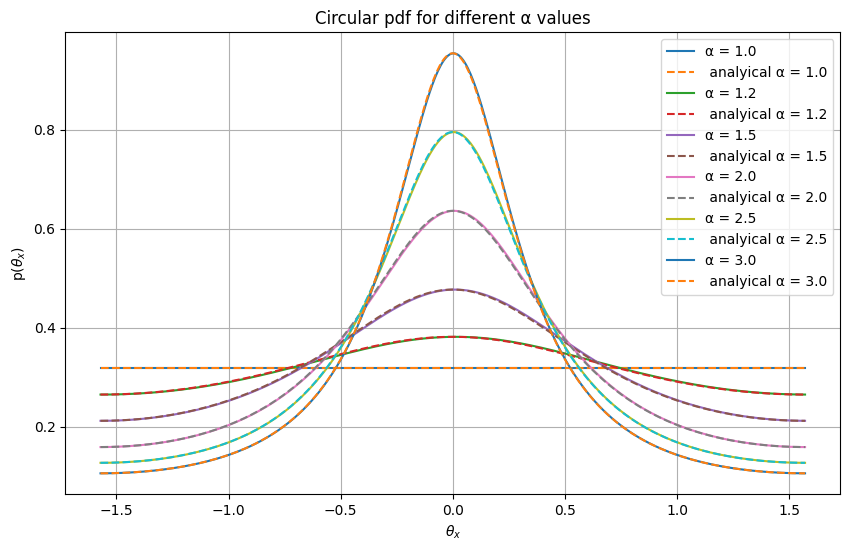

In [5]:
# Constants
Gamma = 1.0
noise = 0.01
c = 1.0  # Constant
alpha_values = [1.0, 1.2, 1.5, 2.0, 2.5, 3.0]

# Solve and normalize solutions for each alpha
solutions = []
for alpha in alpha_values:
    theta_x, normalized_solution = solve_for_alpha(alpha, noise)
    solutions.append((alpha, theta_x, normalized_solution))

# Plot each normalized solution as a function of θ_x
plt.figure(figsize=(10, 6))
for alpha, theta_x, normalized_solution in solutions:
    plt.plot(theta_x, normalized_solution, label=f"α = {alpha}")
    no_noise_analytical = alpha/(np.pi*(1+(alpha**2-1)*(np.sin(theta_x)**2)))
    plt.plot(theta_x, no_noise_analytical, label=f" analyical α = {alpha}", linestyle='--')

plt.xlabel("$\\theta_x$")
plt.ylabel("p($\\theta_x$)")
plt.title("Circular pdf for different α values")
plt.legend()
plt.grid(True)
plt.show()

In the small noise limit we recover the exact solution.

## Reading the data from simulations

*change the input directory and the logic to read data from other files*

In [6]:
def read_pdf_thetax(directory, fixed_cof, fixed_I, aspect_ratios):
    
    os.chdir(directory)
    #initilize data list
    actual_data = []
    # Loop over the aspect ratios (ap)
    for idx, ap in enumerate(aspect_ratios):
        filename = f'simple_shear_ap{ap}_cof_{fixed_cof}_I_{fixed_I}.pkl'
        if os.path.exists(filename):
            with open(filename, 'rb') as file:
                file_data = pickle.load(file)
                
                # Extract the PDF data
                pdf_data = file_data.get('pdf_thetax', None)
                
                if pdf_data is not None and pdf_data.shape == (180, 2):
                    pdf_values = pdf_data[:, 1]  # The PDF values
                    bin_centers = pdf_data[:, 0]  # The bin centers
                    if ap<1:
                        bin_centers = bin_centers + np.pi/2
                        bin_centers = np.where(bin_centers>np.pi/2, bin_centers-np.pi, bin_centers)
                          # Sort the data to avoid crossing boundaries
                        sorted_indices = np.argsort(bin_centers)
                        bin_centers = bin_centers[sorted_indices]
                        pdf_values = pdf_values[sorted_indices]
                    reshaped_tuple = tuple((bin_centers, pdf_values))
                    actual_data.append(reshaped_tuple)
    return actual_data

## Fitting the data with power-law of rotational diffusion and noise

In [7]:
def epsilon_exponent(alpha, noise, exponent):
    """
    Epsilon function with exponent as a parameter
    """
    return noise * alpha**-exponent

### We define an error function which takes the L_2 norm difference of all the shape at the same time. Threfore we attempt to minimize the difference of the fit, for all values of alpha and just two fitting parameters

In [8]:
def solve_for_alpha_fit(alpha_value, noise, exponent):

    epsilon_with_params = lambda alpha: epsilon_exponent(alpha, noise, exponent)

    # Define the theta_x range and an initial guess for the solution
    theta_x = np.linspace(-np.pi / 2, np.pi / 2, 180)
    initial_guess = np.ones((1, theta_x.size))  # Initial guess for p(θ_x)

    sol = solve_bvp(
        lambda theta_x, p: ode(theta_x, p, alpha_value, epsilon_with_params),
        boundary_conditions,
        theta_x,
        initial_guess
    )
    # Normalize the solution
    if sol.success:
        p_values = sol.sol(theta_x)[0]
        integral_value = np.trapezoid(p_values, theta_x)  # Integrate using trapezoidal rule
        normalized_solution = p_values / integral_value
        return theta_x, normalized_solution
    else:
        raise RuntimeError("BVP solver failed to converge")

# Define the error function for optimization
def error_function(params, actual_data, alpha_values):
    noise, exponent = params  # Unpack parameters
    error = 0.0

    # Loop over each alpha value and compare model to data
    for i, alpha in enumerate(alpha_values):
        # Solve the model with the current parameters
        _, model_solution = solve_for_alpha_fit(alpha, noise, exponent)

        # Get the actual data for this alpha value
        actual_theta_x, actual_p = actual_data[i]

        # Interpolate the model solution to the actual data points
        model_interpolated = np.interp(actual_theta_x, np.linspace(-np.pi/2, np.pi/2, len(model_solution)), model_solution)

        # Compute the squared error
        error += np.sum((actual_p - model_interpolated)**2)

    return error

/home/jacopo/Documents/phd_research/Data_processing_simple_shear/output_data_final
True
Optimized Noise: 0.5863322468926374
Optimized Exponent: 2.2674963627585596


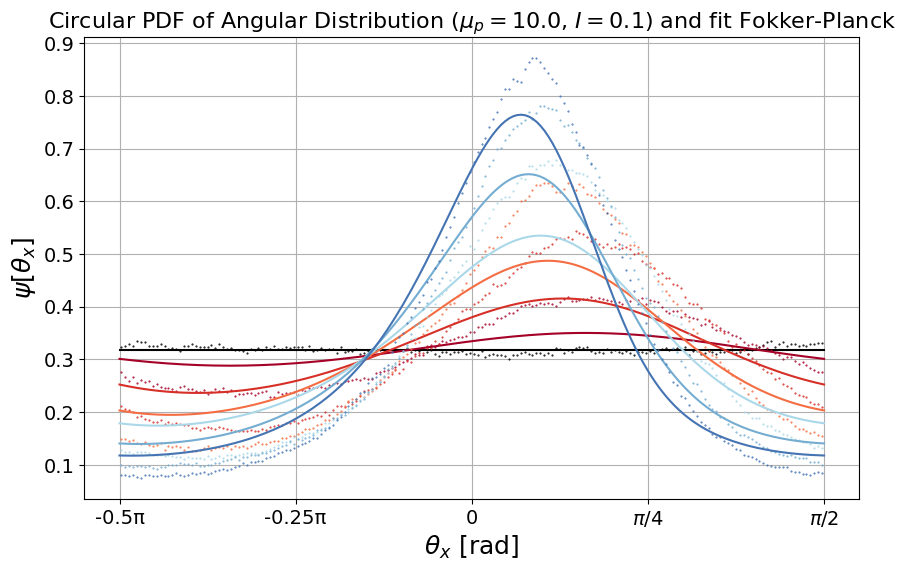

In [9]:
# alpha_values = [0.33, 0.4, 0.5, 0.56, 0.67, 0.83, 1.0] 
alpha_values = [1.0, 1.2, 1.5, 1.8 ,2.0 ,2.5 ,3.0] 
# alpha_values = [1.0, 2.0]
cof = 10.0
I=0.1
# Initial guess for the parameters (noise and exponent)
initial_guess = [1, 2]

# alpha_values = alpha_values[::-1]
# Format: [(theta_x array, p(theta_x) array), ...]
directory = "/home/jacopo/Documents/phd_research/Data_processing_simple_shear/output_data_final/"
actual_data = read_pdf_thetax(directory, cof, I, alpha_values)
print(os.getcwd())
alpha_values = [1/alpha if alpha <1 else alpha for alpha in alpha_values]  

# Perform the optimization
result = minimize(error_function, initial_guess, args=(actual_data, alpha_values),
                  method='L-BFGS-B', tol = 1e-6, options={'maxiter':10000})

# Extract the optimized parameters
optimized_noise, optimized_exponent = result.x
print(result.success)
print(f"Optimized Noise: {optimized_noise}")
print(f"Optimized Exponent: {optimized_exponent}")

plot_pdf_and_fit(alpha_values, optimized_noise, optimized_exponent)


This simple fit does not seem to work well enough. Underestimation of peak at low alpha and overestimation at high alpha.

Moreover, the solution is extremely sensitive to the initial conditions.

Even a grid search can not find a much better solution

Optimized noise: 0.32105263157894737
Optimized exponent: 1.526315789473684


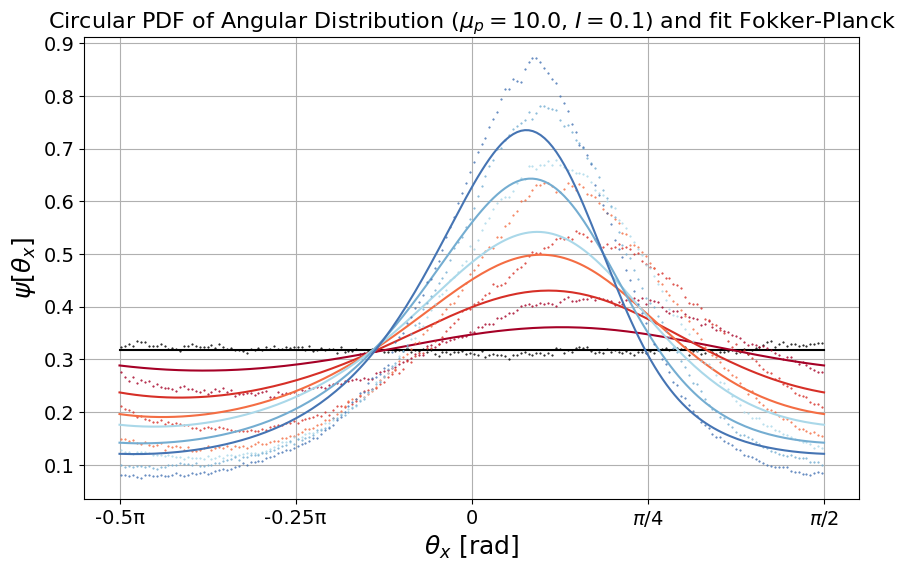

In [10]:
# Define the parameter grid
noise_values = np.linspace(0.1, 1.5, 20)  # Grid for noise
exponent_values = np.linspace(1.0, 2.0, 20)  # Grid for exponent

# Initialize variables to track the best solution
best_error = float('inf')
best_params = None

# Perform grid search
for noise, exponent in itertools.product(noise_values, exponent_values):
    params = [noise, exponent]
    current_error = error_function(params, actual_data, alpha_values)
    
    if current_error < best_error:
        best_error = current_error
        best_params = params

# Extract the optimized parameters
optimized_noise, optimized_exponent = best_params
print("Optimized noise:", optimized_noise)
print("Optimized exponent:", optimized_exponent)
plot_pdf_and_fit(alpha_values, optimized_noise, optimized_exponent)

## Fitting data with power-law elongation and noise

Here we try to fix the rotational diffusion with a power-law and fit the elongation alpha of the grains.
The basic idea is that a grain has an "effective shape" 

In [11]:
def epsilon_alpha_squared(alpha, noise):
    return noise * alpha**-6

def solve_for_alpha_fit(alpha_value, noise, factor_alpha):

    alpha_value = alpha_value**factor_alpha
    # alpha_value *= factor_alpha
    # Define the theta_x range and an initial guess for the solution
    theta_x = np.linspace(-np.pi / 2, np.pi / 2, 180)
    initial_guess = np.ones((1, theta_x.size))  # Initial guess for p(θ_x)

    epsilon = lambda alpha: epsilon_alpha_squared(alpha, noise)
    
    sol = solve_bvp(
        lambda theta_x, p: ode(theta_x, p, alpha_value, epsilon),
        boundary_conditions,
        theta_x,
        initial_guess
    )
    # Normalize the solution
    if sol.success:
        p_values = sol.sol(theta_x)[0]
        integral_value = np.trapezoid(p_values, theta_x)  # Integrate using trapezoidal rule
        normalized_solution = p_values / integral_value
        return theta_x, normalized_solution
    else:
        raise RuntimeError("BVP solver failed to converge")

# Define the error function for optimization
def error_function(params, actual_data, alpha_values):
    noise, factor_alpha = params  # Unpack parameters
    error = 0.0

    # Loop over each alpha value and compare model to data
    for i, alpha in enumerate(alpha_values):
        # Solve the model with the current parameters
        _, model_solution = solve_for_alpha_fit(alpha, noise, factor_alpha)

        # Get the actual data for this alpha value
        actual_theta_x, actual_p = actual_data[i]

        # Interpolate the model solution to the actual data points
        model_interpolated = np.interp(actual_theta_x, np.linspace(-np.pi/2, np.pi/2, len(model_solution)), model_solution)

        # Compute the squared error
        error += np.sum((actual_p - model_interpolated)**2)

    return error

Optimized noise: 5.0
Optimized factor: 2.0


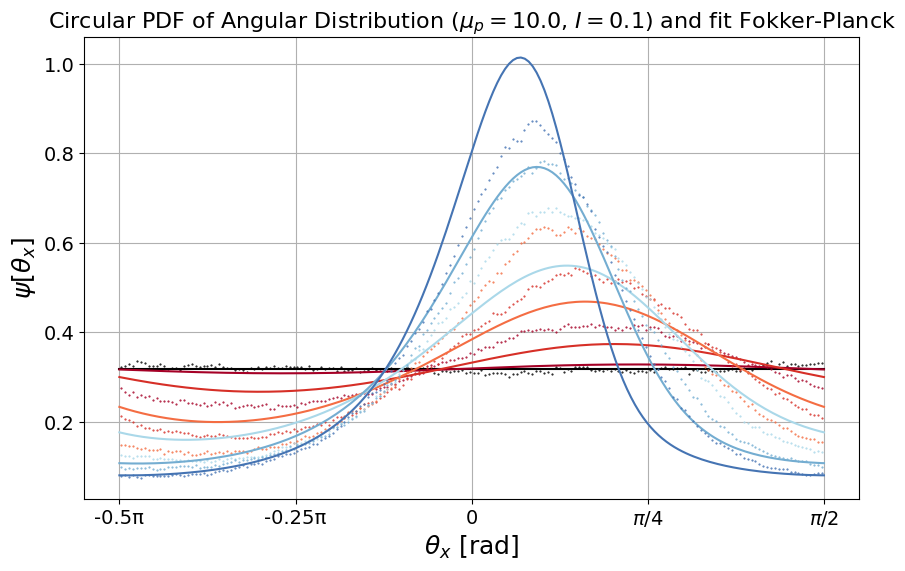

In [12]:
# Define the parameter grid
noise_values = np.linspace(0.1, 5, 50)  # Grid for noise
factor_values = np.linspace(0.5, 5, 50)  # Grid for factor

# Initialize variables to track the best solution
best_error = float('inf')
best_params = None

# Perform grid search
for noise, factor in itertools.product(noise_values, factor_values):
    params = [noise, exponent]
    current_error = error_function(params, actual_data, alpha_values)
    
    if current_error < best_error:
        best_error = current_error
        best_params = params

# Extract the optimized parameters
optimized_noise, optimized_factor = best_params
print("Optimized noise:", optimized_noise)
print("Optimized factor:", optimized_factor)
plot_pdf_and_fit(alpha_values, optimized_noise, optimized_exponent)

Fitting one shape at a time yields better results, at least for the high inertia and high frictional case

True
Optimized Noise: 1.5675051439132002
Optimized Exponent: 1.1315052641208998


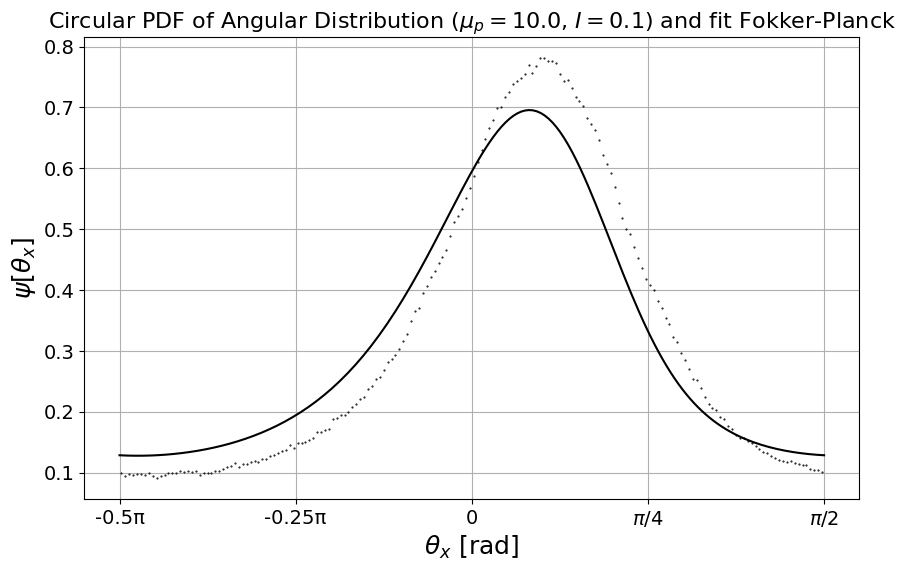

In [13]:
alpha_values = [2.5] 
actual_data = read_pdf_thetax(directory, cof, I, alpha_values)
# Initialize variables to track the best solution
# Perform the optimization
result = minimize(error_function, initial_guess, args=(actual_data, alpha_values),
                  method='L-BFGS-B', tol = 1e-6, options={'maxiter':10000})

# Extract the optimized parameters
optimized_noise, optimized_exponent = result.x
print(result.success)
print(f"Optimized Noise: {optimized_noise}")
print(f"Optimized Exponent: {optimized_exponent}")

plot_pdf_and_fit(alpha_values, optimized_noise, optimized_exponent)

Fitting the distribution with the same exponent, probably does not work on low microscopic frictions

True
Optimized Noise: 1.1989548034396296
Optimized Exponent: 1.2151758017186411


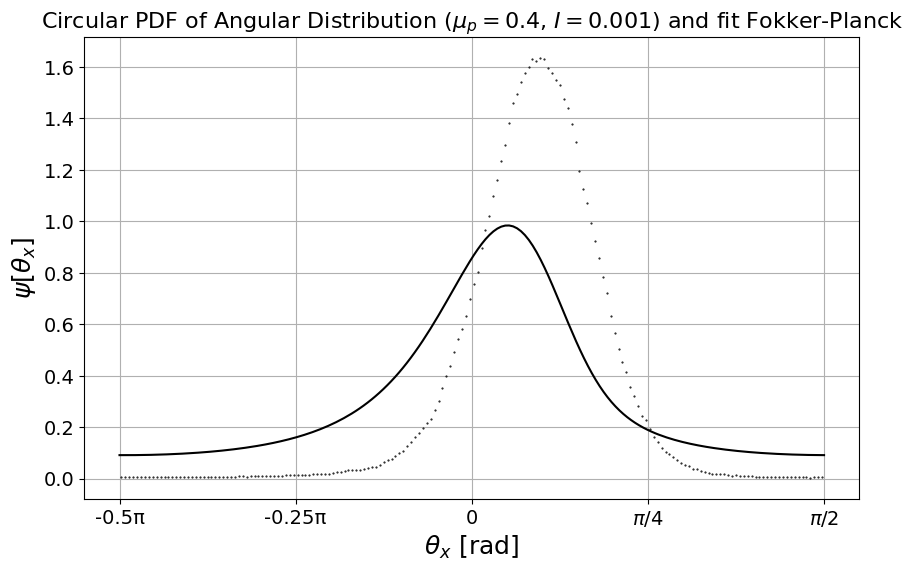

In [14]:
alpha_values = [3.0] 
cof = 0.4
I=0.001
intitial_guess = [1.9, 4]

actual_data = read_pdf_thetax(directory, cof, I, alpha_values)
# Initialize variables to track the best solution
# Perform the optimization
result = minimize(error_function, initial_guess, args=(actual_data, alpha_values),
                  method='L-BFGS-B', tol = 1e-6, options={'maxiter':10000})

# Extract the optimized parameters
optimized_noise, optimized_exponent = result.x
print(result.success)
print(f"Optimized Noise: {optimized_noise}")
print(f"Optimized Exponent: {optimized_exponent}")

plot_pdf_and_fit(alpha_values, optimized_noise, optimized_exponent)

/tmp/ipykernel_6890/3060986146.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fixed_alpha_model, actual_theta_x, actual_p, p0=initial_guess)


Alpha: 1.0, Noise: 1.0, Exponent: 1.0
Alpha: 1.2, Noise: 117.07024537651462, Exponent: 9.840353755093332
Alpha: 1.5, Noise: 78.85873523894847, Exponent: 4.716829740111534
Alpha: 2.0, Noise: 32.55129847855348, Exponent: 2.6569851298099927
Alpha: 2.5, Noise: 20.778069310727258, Exponent: 2.052875709416004
Alpha: 3.0, Noise: 9.203940622439314, Exponent: 1.5690640967739309


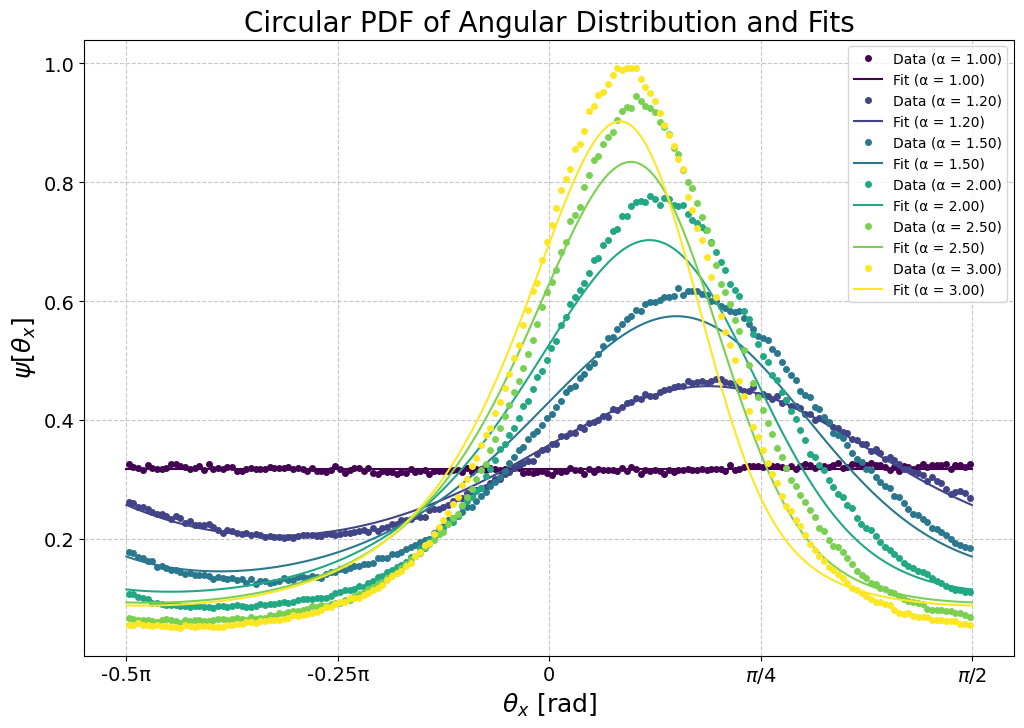

In [22]:
from scipy.optimize import curve_fit
# Define the model function for curve_fit
def model(thetax, noise, exponent, alpha):
    # Solve the BVP for the given parameters
    _, model_solution = solve_for_alpha_fit(alpha, noise, exponent)
    # Interpolate the solution at the given theta_x values
    interpolated_solution = np.interp(thetax, np.linspace(-np.pi/2, np.pi/2, len(model_solution)), model_solution)
    return interpolated_solution


# Loop over each alpha value and fit noise and exponent
optimized_params = []
for i, alpha in enumerate(alpha_values):
    actual_theta_x, actual_p = actual_data[i]  # Extract data for this alpha
    
    # Wrap the model to pass the fixed alpha value
    def fixed_alpha_model(thetax, noise, exponent):
        return model(thetax, noise, exponent, alpha)
    
    # Perform the curve fitting
    initial_guess = [1.0, 1.0]  # Example initial guesses for noise and exponent
    popt, pcov = curve_fit(fixed_alpha_model, actual_theta_x, actual_p, p0=initial_guess)
    
    # Store the optimized parameters
    optimized_params.append({'alpha': alpha, 'noise': popt[0], 'exponent': popt[1]})

cof = 10.0
I=0.001
alpha_values = [1.0, 1.2, 1.5, 2.0, 2.5, 3.0]
intitial_guess = [4, 2]

actual_data = read_pdf_thetax(directory, cof, I, alpha_values)
# Print or analyze the results
for result in optimized_params:
    print(f"Alpha: {result['alpha']}, Noise: {result['noise']}, Exponent: {result['exponent']}")

# Plot function
def plot_actual_and_fits(alpha_values, actual_data, optimized_params):
    plt.figure(figsize=(12, 8))
    
    colormap = plt.cm.viridis
    num_colors = len(alpha_values)
    colors = [colormap(i) for i in np.linspace(0, 1, num_colors)]
    
    # Loop over each alpha value
    for i, result in enumerate(optimized_params):
        alpha = result['alpha']
        noise = result['noise']
        exponent = result['exponent']
        
        # Solve the model with optimized parameters
        theta_x, model_solution = solve_for_alpha_fit(alpha, noise, exponent)
        
        # Get the actual data for this alpha value
        actual_theta_x, actual_p = actual_data[i]
        
        # Plot the actual data
        plt.plot(actual_theta_x, actual_p, 'o', markersize=4, label=f"Data (α = {alpha:.2f})", color=colors[i])
        
        # Plot the model solution
        plt.plot(theta_x, model_solution, '-', label=f"Fit (α = {alpha:.2f})", color=colors[i])
    
    # Customize the plot
    plt.xlabel('$\\theta_x$ [rad]', fontsize=18)
    plt.ylabel('$\\psi[\\theta_x]$', fontsize=18)
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=np.pi / 4))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    plt.gca().tick_params(axis='x', labelsize=14)
    plt.gca().tick_params(axis='y', labelsize=14)
    
    plt.title('Circular PDF of Angular Distribution and Fits', fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.show()

# Example call to the function
plot_actual_and_fits(alpha_values, actual_data, optimized_params)

In [16]:
from scipy.optimize import curve_fit
# Define the model function for curve_fit
def model(thetax, exponent, alpha):
    # Solve the BVP for the given parameters
    _, model_solution = solve_for_alpha_fit(alpha, exponent)
    # Interpolate the solution at the given theta_x values
    interpolated_solution = np.interp(thetax, np.linspace(-np.pi/2, np.pi/2, len(model_solution)), model_solution)
    return interpolated_solution

# Loop over each alpha value and fit noise and exponent
optimized_params = []
for i, alpha in enumerate(alpha_values):
    actual_theta_x, actual_p = actual_data[i]  # Extract data for this alpha
    
    # Wrap the model to pass the fixed alpha value
    def fixed_alpha_model(thetax,exponent):
        return model(thetax, exponent, alpha)
    
    # Perform the curve fitting
    initial_guess = [3.0]  # Example initial guesses for noise and exponent
    popt, pcov = curve_fit(fixed_alpha_model, actual_theta_x, actual_p, p0=initial_guess)
    
    # Store the optimized parameters
    optimized_params.append({'alpha': alpha, 'exponent': popt[0]})

cof = 10.0
I=0.1
intitial_guess = [3]

actual_data = read_pdf_thetax(directory, cof, I, alpha_values)
# Print or analyze the results
for result in optimized_params:
    print(f"Alpha: {result['alpha']}, Exponent: {result['exponent']}")

# Plot function
def plot_actual_and_fits(alpha_values, actual_data, optimized_params):
    plt.figure(figsize=(12, 8))
    
    colormap = plt.cm.viridis
    num_colors = len(alpha_values)
    colors = [colormap(i) for i in np.linspace(0, 1, num_colors)]
    
    # Loop over each alpha value
    for i, result in enumerate(optimized_params):
        alpha = result['alpha']
        exponent = result['exponent']
        
        # Solve the model with optimized parameters
        theta_x, model_solution = solve_for_alpha_fit(alpha, exponent)
        
        # Get the actual data for this alpha value
        actual_theta_x, actual_p = actual_data[i]
        
        # Plot the actual data
        plt.plot(actual_theta_x, actual_p, 'o', markersize=4, label=f"Data (α = {alpha:.2f})", color=colors[i])
        
        # Plot the model solution
        plt.plot(theta_x, model_solution, '-', label=f"Fit (α = {alpha:.2f})", color=colors[i])
    
    # Customize the plot
    plt.xlabel('$\\theta_x$ [rad]', fontsize=18)
    plt.ylabel('$\\psi[\\theta_x]$', fontsize=18)
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=np.pi / 4))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    plt.gca().tick_params(axis='x', labelsize=14)
    plt.gca().tick_params(axis='y', labelsize=14)
    
    plt.title('Circular PDF of Angular Distribution and Fits', fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.show()

# Example call to the function
plot_actual_and_fits(alpha_values, actual_data, optimized_params)

TypeError: solve_for_alpha_fit() missing 1 required positional argument: 'factor_alpha'